# Ejercicio 2

Para esta seccion, seleccionamos de nuevo el corpus **cess_es** y lo preprocesamos de la misma manera que en el ejercicio 1

In [6]:
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math   

from preprocesador import *
from subword import *
from frecuencias import *

os.environ["NLTK_DATA"]="datos_nltk/"
import  nltk
from nltk.corpus import stopwords

## Paso 1
Preprocesamos el corpus

In [7]:
## Seleccionamos el corpus
from nltk.corpus import cess_esp

nltk.download("cess_esp")

## Obtenemos las oraciones del corpus para el entrenamiento de nuestra red neuronal
corpus_sents = cess_esp.sents()[0:1000]

print("Numero de oraciones en el corpus:", len(corpus_sents))

[nltk_data] Downloading package cess_esp to /home/joel/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Numero de oraciones en el corpus: 1000


In [8]:
# Procedemos a normalizar el texto:
nltk.download('stopwords')
stopwords_list = stopwords.words('spanish')

# Normalizamos los oraciones
sents_norm = [pre_procesar(oracion, stopwords_list) for oracion in corpus_sents]
# Obtenemos todas las palabras del texto
tokens_normalizados = [x for xs in sents_norm for x in xs]

print("Numero de tokens, despues del preprocesamiento:", len(tokens_normalizados))

[nltk_data] Downloading package stopwords to /home/joel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Numero de tokens, despues del preprocesamiento: 17801


In [9]:
# Entrenamos nuestro algoritmo de BPE con las palabras del corpus, 
# obtenemos las reglas y las frecuencias de cada token
freqs_bpe, reglas_bpe = entrenar_byte_pair_encoding(tokens_normalizados, 1000)

In [10]:
# Aplicamos nuestro modelo bpe a cada oracion para obtener las oraciones tokenizadas
sents_tokenizadas = [aplicar_bpe(sent, reglas_bpe) for sent in sents_norm]

# Agregamos la etiqueta <BOS> a cada oracion
sents_tokenizadas = [["<BOS>"] + sent for sent in sents_tokenizadas]


In [11]:
# Construimos la tabla para las frecuencias de las palabras
tabla_frecuencias_bpe = crear_tabla_frecuencias(freqs_bpe)
print(tabla_frecuencias_bpe)

       palabra  frecuencia
0            a         275
1           to         223
2           de         205
3            o         181
4           ta         169
...        ...         ...
5444  salarios           1
5445   miseria           1
5446      eria           1
5447   mineros           1
5448     pleta           1

[5449 rows x 2 columns]


In [12]:
#Convertimos la tabla en un diccionario para usarlo en el modelo
palabras = tabla_frecuencias_bpe['palabra']
frecuencias = tabla_frecuencias_bpe['frecuencia']
dic_palabras = {}  
for i in range(len(frecuencias)):
    dic_palabras[palabras[i]] = frecuencias[i]
dic_palabras["<BOS>"] = len(sents_norm)
dic_palabras["<EOS>"] = len(sents_norm)

In [13]:
ETIQUETA_UNK = "<UNK>"
def indices_palabras(palabras_frecuencias: dict):
    """Calcula los indices de las palabras dadas sus frecuencias

    Parameters
    ----------
    palabras_frecuencias : dict
        Diccionario donde las llaves son las palabras y los valores sus frecuencias

    Returns
    -------
    dict,dict
        Diccionarios uno a uno de palabras a indices y viceversa
    """
    result = {}
    for ind, palabra in enumerate(palabras_frecuencias.keys()):
        # Ocurrio un Happax legomena o singleton
        if palabras_frecuencias[palabra] == 1:
            # Indice temporal para UNK
            result[ETIQUETA_UNK] = len(palabras_frecuencias)
        else:
            result[palabra] = ind

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [14]:
#Se obtienen los índices de cada palabra
palabras_a_indices, indices_a_palabras = indices_palabras(dic_palabras)
print(palabras_a_indices)
print(indices_a_palabras)
len(palabras_a_indices)

{'a': 0, 'to': 1, 'de': 2, 'o': 3, 'ta': 4, 'do': 5, 'c': 6, 'co': 7, 'con': 8, 'hoy': 9, 're': 10, 'es': 11, 'al': 12, 'en': 13, 'te': 14, 'ex': 15, 'mo': 16, 'dos': 17, 'gobierno': 18, 'da': 19, 'ca': 20, 'f': 21, 'se': 22, 'h': 23, 'i': 24, 'z': 25, 'cia': 26, 'e': 27, 'l': 28, 'tar': 29, 's': 30, 'b': 31, 'presidente': 32, 'ti': 33, 't': 34, 'tos': 35, 'pro': 36, 'p': 37, 'tas': 38, 'li': 39, 'des': 40, 'pais': 41, 'años': 42, '6': 43, 'que': 44, 'ento': 45, 'd': 46, 'fe': 47, 'ro': 48, 'ce': 49, 'tes': 50, 'fi': 51, 'segun': 52, '2': 53, 'in': 54, 'com': 55, 'paises': 56, 'ci': 57, 'ter': 58, 'jo': 59, 'g': 60, '3': 61, '4': 62, 'dijo': 63, 'an': 64, 'ar': 65, 'ra': 66, 'si': 67, 'y': 68, 'millones': 69, 'im': 70, '1': 71, 'di': 72, 'k': 73, 'le': 74, 'su': 75, 'm': 76, '5': 77, '9': 78, 'per': 79, 'dis': 80, 'vo': 81, 'tado': 82, 'lo': 83, 'res': 84, '7': 85, 'tras': 86, 'mente': 87, 've': 88, 'no': 89, 'la': 90, 'pasado': 91, 'sido': 92, 'año': 93, 'cos': 94, 'vi': 95, '0': 96, 

3152

In [15]:
def get_id(palabra_a_id: dict, palabra: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK

    Parameters
    ----------
    palabra_a_id : dict
        Diccionario de palabras a indices
    palabra : str
        Palabra a buscar

    Returns
    -------
    int
        Indice de la palabra
    """
    id_unknow = palabra_a_id[ETIQUETA_UNK]
    return palabra_a_id.get(palabra, id_unknow)

In [16]:
def lista_indices(corpus:list, palabras_a_indices:dict) -> list:
    """Genera una lista de indices que representan las palabras de un corpus 
    Parameters
    ----------
    corpus : list
        corpus a procesar
    indices_a_palabras : dict
        Diccionario de palabras a indices
    Returns
    -------
    list
        Lista de indices que representan las palabras del corpus
    """
    indices = []
    for sent in corpus:
        renglon = []
        for token in sent:
            renglon.append(get_id(palabras_a_indices, token))
        indices.append(renglon)
    return indices

In [17]:
def lista_siguientes(entradas : list) -> list:
    """
    Genera una lista de palabras siguientes a partir de una lista de palabras.
    Parameters
    ----------
    entradas : list
        lista de listas de palabras, donde cada lista tiene 
        como primer elemento la etiqueta <BOS>.
    Returns
    -------
    list
        Lista de listas donde cada palabra es la palabra que le sigue 
        en la entrada, o la etiqueta <EOS> si es la última de la lista.
    """
    salidas = []
    for sent in entradas:
        renglon = []
        for i in range(len(sent)-1):
            renglon.append(sent[i+1])    
        renglon.append("<EOS>")                
        salidas.append(renglon)
    return(salidas)

In [18]:
#Obtenemos los índices de cada oración
indices_sents = lista_indices(sents_tokenizadas, palabras_a_indices)
print(indices_sents[0])
print(sents_tokenizadas[0])

[3150, 182, 11, 2068, 1176, 57, 3149, 184, 49, 565, 21, 327, 9, 517, 934, 77, 71, 170, 194, 514, 425, 1176, 57, 3149, 3149, 1708, 1200, 0, 2030, 2883, 98, 34, 2524, 104, 177, 2369, 1715, 889, 1210, 737, 62, 78, 77, 144, 185, 2159]
['<BOS>', 'grupo', 'es', 'tatal', 'electri', 'ci', 'tede', 'fran', 'ce', 'ed', 'f', 'anuncio', 'hoy', 'jueves', 'compra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'electri', 'ci', 'dadagui', 'ladeal', 'tamira', 'ea', 'a', 'creada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'marcha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios']


In [19]:
#Obtenemos las palabras siguientes y sus índices que se usarán para el entrenamiento 
siguientes_tokenizadas = lista_siguientes(sents_tokenizadas)
indices_siguientes = lista_indices(siguientes_tokenizadas, palabras_a_indices)

print(siguientes_tokenizadas[0])
print(indices_siguientes[0])

['grupo', 'es', 'tatal', 'electri', 'ci', 'tede', 'fran', 'ce', 'ed', 'f', 'anuncio', 'hoy', 'jueves', 'compra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'electri', 'ci', 'dadagui', 'ladeal', 'tamira', 'ea', 'a', 'creada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'poneren', 'marcha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios', '<EOS>']
[182, 11, 2068, 1176, 57, 3149, 184, 49, 565, 21, 327, 9, 517, 934, 77, 71, 170, 194, 514, 425, 1176, 57, 3149, 3149, 1708, 1200, 0, 2030, 2883, 98, 34, 2524, 104, 177, 2369, 1715, 889, 1210, 737, 62, 78, 77, 144, 185, 2159, 3151]


## Paso 2 
Construimos la red neuronal recurrente usando pytorch y el módulo RNN

In [20]:
import torch    
import torch.nn as nn

In [21]:
class RecurrentNetwork(nn.Module):
    def __init__(self, dim_in, dim_out, dim=100, dim_h=200):
        super().__init__()
        #Capa de embedding
        self.emb = nn.Embedding(dim_in,dim)
        #Capa de RNN (bidireccional)
        self.recurrence = nn.RNN(dim, dim_h, bidirectional=True)
        #Capa lineal
        lineal = nn.Linear(2*dim_h,dim_out)
        #Activacion
        pre = nn.Softmax(dim=2)
        #Salida
        self.ffw = nn.Sequential(lineal, pre)
        
    def forward(self, x):
        #Se convierte en tensor
        x = torch.tensor(x)
        #Embedding
        x = self.emb(x)
        x = x.unsqueeze(1)
        #Capas recurrentes
        h, c = self.recurrence(x)
        #Activación
        h = h.tanh()
        #Salida
        y_pred = self.ffw(h)
        y_pred = y_pred.transpose(1, 2)
        return y_pred

    def get_emb(self):
        return self.emb

In [22]:
#Se crea la red recurrente
#Numero de iteraciones
EPOCHS = 10
#Taza de aprendizaje
LEARNING_RATE = 0.005
#Dimension
dim = 2

#Se crea la red
rnn = RecurrentNetwork(len(indices_a_palabras.keys()), len(indices_a_palabras.keys()))

#Se definen los conjuntos de entradas y salidas
x = indices_sents
y = indices_siguientes

#Se define la función de riesgo y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(rnn.parameters(), LEARNING_RATE)

In [23]:
%%time

losses = []
#Se entrena el modelo
for epoch in range(EPOCHS):
    for x_i, y_i in zip(x, y):
        #Forward
        y_pred = rnn(x_i)

        #Backward
        y_i = (torch.tensor(y_i)).unsqueeze(1)

        #Se calcula el eror
        loss = criterion(y_pred, y_i)

        #Reiniciamos los gradientes a cero
        optimizer.zero_grad(set_to_none=True)
        #Backpropagation
        loss.backward()
        #Actualizamos parametros
        optimizer.step()

    losses.append(loss.detach().numpy())
    print(f"Epoch={epoch}. Training loss={loss}")


Epoch=0. Training loss=7.97302770614624
Epoch=1. Training loss=7.973011016845703
Epoch=2. Training loss=7.972952365875244
Epoch=3. Training loss=7.972936630249023
Epoch=4. Training loss=7.972925186157227
Epoch=5. Training loss=7.972927093505859
Epoch=6. Training loss=7.9729156494140625
Epoch=7. Training loss=7.972911357879639
Epoch=8. Training loss=7.972907543182373
Epoch=9. Training loss=7.972903728485107
CPU times: user 20min 55s, sys: 2min 6s, total: 23min 1s
Wall time: 6min 43s


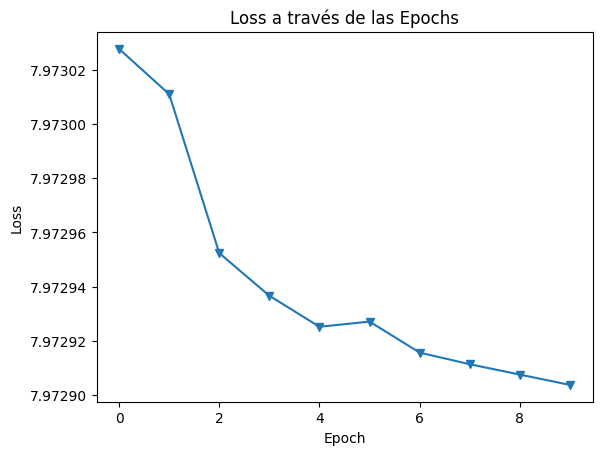

In [24]:
#Graficamos los diferentes losses a través de las iteraciones
plt.plot(losses, 'v-')
plt.title('Loss a través de las Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
def get_valor(tupla : tuple) -> any:
    """Obtiene el valor de una tupla con al menos 2 valores"""
    return tupla[1]

def get_proba(corpus_eval : list, palabras_a_ind : dict, sort_func) -> list:
    """
    Obtiene las probabilidades de cada palabra en corpus_eval ordenadas según el criterio de sort_func.
    Parameters
    ----------
    corpus_eval : list
        lista de cadenas de las cuáles se obtendrán sus probabilidades.
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    sort_func : any
        Función que indica sobre qué criterio debe ordenarse las probabilidades.
    Returns
    -------
    list
        Lista de listas donde se guardan las probabilidades de cada palabra.
    """
    probas = []
    ind_corpus = [palabras_a_ind[w] for w in corpus_eval]
    output = rnn(ind_corpus)
    for i in range(len(corpus_eval)):
        renglon = []
        for j in range(len(palabras_a_ind.keys())):
            palabras = list(palabras_a_ind.keys())
            valor = output[i][j].item()
            renglon.append((palabras[j], valor))
        renglon.sort(key=sort_func, reverse=True)
        probas.append(renglon)
    return probas


In [26]:
#Obtenemos las probabilidades para unos tokens de ejemplo, ordenadas de mayor a menor.
prueba = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
probas = get_proba(prueba, palabras_a_indices, get_valor)
for p in range(len(probas)):
    print(f"Probas para {prueba[p]}")
    for proba in probas[p][0:10]:
        print(proba)
    print("")

Probas para <BOS>
('f', 0.6012886762619019)
('<UNK>', 0.19806557893753052)
('a', 0.1472799926996231)
('<EOS>', 0.046183325350284576)
('ed', 0.0031303127761930227)
('al', 0.00025879888562485576)
('tamira', 0.00021455662499647588)
('ci', 0.00015789266035426408)
('re', 8.957841782830656e-05)
('5', 6.016660336172208e-05)

Probas para grupo
('f', 0.5256035327911377)
('a', 0.4081414043903351)
('<UNK>', 0.043006446212530136)
('<EOS>', 0.023009715601801872)
('tamira', 3.393900624359958e-05)
('ed', 3.188104528817348e-05)
('al', 1.616004010429606e-05)
('ci', 1.2464904102671426e-05)
('re', 4.638732661987888e-06)
('electri', 2.9672603432118194e-06)

Probas para es
('<UNK>', 0.9514469504356384)
('<EOS>', 0.04491773992776871)
('a', 0.002842219080775976)
('f', 0.0007424904033541679)
('ed', 7.42763040761929e-06)
('tamira', 5.73368060940993e-06)
('al', 2.4411706363025587e-06)
('ci', 2.2117224034445826e-06)
('5', 6.58526460028952e-07)
('me', 5.635807838189066e-07)

Probas para tatal
('<EOS>', 0.99652594

## Paso 3: 
Evaluamos el modelo usando perplejidad

In [27]:
def get_perplexity(corpus_eval : list, palabras_a_ind : dict) -> float:
    """
    Obtiene el valor de perplejidad de la red con las palabras en corpus_eval
    ----------
    corpus_eval : list
        lista de cadenas de las cuáles se obtendrá el valor de perplejidad.
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    Returns
    -------
    float
        Valor de perplejidad de las palabras.
    """
    perplexity = 0
    indices_corpus = []
    for token in corpus_eval:
        if token in palabras_a_ind.keys():
            indices_corpus.append(palabras_a_ind[token])
        else:
            indices_corpus.append(palabras_a_ind["<UNK>"])
            
    output = rnn(indices_corpus)
    probas = []
    for i in range(len(output)-1):
        probas.append(output[i][indices_corpus[i+1]].item())

    for p in probas:
        if(perplexity != 0):
            perplexity != 1/p
        else:
            perplexity = 1/p
    return perplexity ** (1/(len(corpus_eval)-2))

In [28]:
#Probando la perplejidad con tokens del corpus
evaluacion = ["<BOS>", "grupo", "es", "tatal", "<EOS>"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 46.294295037171786


In [29]:
#Probando la perplejidad con tokens en desorden
evaluacion = ["<EOS>", "tatal", "a", "grupo"]
perplejidad = get_perplexity(evaluacion, palabras_a_indices)
print(f"Perplejidad de la oración: {perplejidad}")

Perplejidad de la oración: 95.02245591445332


## Paso 4 
Usando el modelo generamos una cadena aleatoria

In [30]:
import random
def generate_words(palabras_a_ind: dict, size: int, n : int) -> str:
    """
    Genera una oración de longitud size con los tokens más probables según la red recurrente.
    Cada token es elegido aleatoriamente de entre los n con mayor probabilidad, si n es mayor
    a la longitud del vocabulario se elige de entre todos los tokens posibles.
    Parameters
    ----------
    palabras_a_ind : dict
        Diccionario de palabras a indices.
    size : int
        Número de palabras a generar.
    n : int
        La cantidad de tókens más probables a elegir.
    Returns
    -------
    list
        Lista de listas donde se guardan las probabilidades de cada palabra.
    """
    oracion = ""
    ultima = "<BOS>"
    for i in range(size):
        result = get_proba([ultima], palabras_a_ind, get_valor)
        siguiente = "<UNK>"
        ind = random.randint(0, min(n, len(result[0])-1))
        while siguiente == "<UNK>": #Se vuelve a elegir si toca un UNK
            siguiente = result[0][ind][0]
            ind = random.randint(0, min(n, len(result[0])-1))
        if(siguiente == "<EOS>"):
            oracion += ". "
        elif(siguiente != "<BOS>"):
            oracion += f"{siguiente} "
        ultima = siguiente
    return oracion

In [31]:
#Generamos la cadena
print("Generando cadena: ")
print(generate_words(palabras_a_indices, 10, 10))

Generando cadena: 
ed ed gas me mi . po . anuncio creada 


## Paso 5 
Visualizamos los embbedings

In [32]:
#Obtenemos todos los embbedings de la red recurrente
last_ind = len(list(indices_a_palabras.keys()))
last_emb = torch.tensor(list(range(last_ind)))

emb_list = []
for ind in indices_a_palabras.keys():
    emb_vector = rnn.emb(last_emb).detach().numpy()[ind]
    emb_list.append(emb_vector)

#Visualizamos uno de los embbedings
palabra_emb = "grupo"
print(f"Word: {palabra_emb} \nEmbedding:\n {emb_list[palabras_a_indices[palabra_emb]]}")


Word: grupo 
Embedding:
 [-0.43993312 -0.6924734   0.23747694  1.1052309   1.5360792   0.4618141
  1.297777   -0.5472545  -0.1545974   1.3585194  -1.536882   -0.8249599
 -0.39699295 -0.8093775  -0.26659954 -0.01719548  0.9782843   1.5254993
  1.4509357  -0.7892833  -0.00868883  0.2929897  -0.86089253 -0.4964891
  0.40729982 -0.08480002 -0.7338844  -1.598753    0.2700121  -0.36076713
 -1.4012504   0.23540235  1.1516628   0.0689921  -0.6225991  -0.44117162
  0.46084213  0.194436   -1.0384507  -1.0307059   0.1066933   1.7290971
  0.41476032  1.085565    1.6418678  -1.3031664  -0.50970304 -0.05127513
  0.7250918   0.38463876 -0.80348545 -0.7287254   0.63917327 -0.5142716
  0.75669545  0.70518714 -0.78660667 -0.68399477  1.5814209   0.3896309
 -0.96241367  2.4615908   1.2781899  -1.7097819   1.1075368   0.61890155
  0.01674087  1.3046571   0.45856163 -1.3472358  -0.9795093  -0.40679654
 -1.067725   -0.8154042  -0.8977792  -0.5521212  -0.22359711 -0.43881622
  0.40097645  0.68323386  0.50982

In [33]:
#Obtenemos los primeros dos valores de cada emmbeding para obtener vectores bidimensionales
two_emb = []
for emb in emb_list:
    elem = [e for e in emb[0:2]]
    two_emb.append(elem)

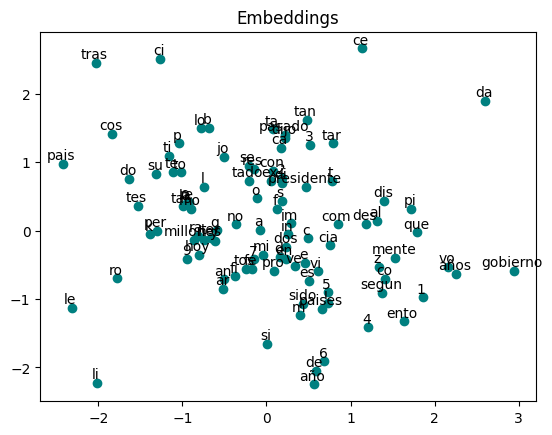

In [34]:
#Graficamos los embbedings bidimensionales
def plot_words(Z, ids):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='teal')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

plot_words(np.array(two_emb)[0:100], list(palabras_a_indices.keys()))
plt.title('Embeddings')
plt.show()